# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** *H*

**Names:**

* *Antoine Basseto*
* *Andrea Pinto*
* *Jérémy Baffou*

---

#### Instructions

*This is a template for part 3 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

In [1]:
import numpy as np
import networkx as nx
import json
import epidemics_helper
import matplotlib.pyplot as plt
import pandas as pd
import part3_functions as part3

Before jumping into the exercices let's load our graph.

In [2]:
with open("../data/nyc_augmented_network.json", "r") as read_file:
    data = json.load(read_file)

In [3]:
nodes_list = list(map(lambda d : (d['id'], {'coordinates' : d['coordinates']}),data["nodes"]))
edges_list = list(map(lambda d : (d['source'],d['target']), data["links"]))

In [4]:
G = nx.Graph()
G.add_nodes_from(nodes_list)
G.add_edges_from(edges_list)

In [ ]:
part3.draw_graph(G)

---

## 2.3 Epidemics

#### Exercise 2.9: Simulate an epidemic outbreak

Let's simulate an epidemy on our network with parameter beta=10.0 and gamma=0.1

In [5]:
SIR = epidemics_helper.SimulationSIR(G, beta=10.0, gamma=0.1)
SIR.launch_epidemic(source=23654, max_time=100.0)

Epidemic stopped after 104.73 days | 104.73 days elapsed | 0.1% susceptible, 0.0% infected, 99.9% recovered


Now we would like to have an idea of its evolution so we plot the number of people in the different states (Susceptible, Infected and Recovered)

In [6]:
time_stamps_status, nodes_status = part3.nodes_status_over_time(SIR, 100, [1,3,30])

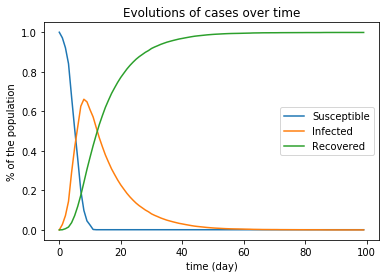

In [7]:
part3.plot_population_status(nodes_status,percentage=True)

In [8]:
part3.epidemic_markers(nodes_status,0.6)

The epidemic has the following evolution : 60.0% of the population stop being susceptible at time 5, is infected at time 7 and has recover at time 15


We can show the evolution of the epidemy on the network:

In [ ]:
fig, axs = plt.subplots(len(time_stamps_status.values()), figsize=(400,500))
fig.suptitle('Epidemic evolution of the network')
i = 0
for stamps, status in time_stamps_status.items():
    axs[i].set_title("At day "+ str(stamps), fontsize=300)
    part3.draw_graph(G,nodes_status=status,ax=axs[i])
    i+=1

We can see that the epidemy spreads very fast as in day one a good portion of the network as already been contaminated even if we started with a single sick node. In day 3 we see that the epidemy is reaching other big chunk of the network (not only in manhattan anymore), which is the starting point for a fully plagued network. a In day 30 nearly every people in the network has been infected and is now recovered, except for some people who are still infected or susceptible

---

### 2.3.1 Stop the apocalypse!

#### Exercise 2.10: Strategy 1

Epidemic stopped after 101.24 days | 101.24 days elapsed | 0.4% susceptible, 0.0% infected, 99.6% recovered
Epidemic stopped after 97.07 days | 97.07 days elapsed | 0.3% susceptible, 0.0% infected, 99.7% recovered
Epidemic stopped after 95.61 days | 95.61 days elapsed | 0.5% susceptible, 0.0% infected, 99.5% recovered
By following strategy random, on day 30, the average of susceptible people is 103.33333333333333, of infected is 2662.0 and of recovered is 23715.666666666668


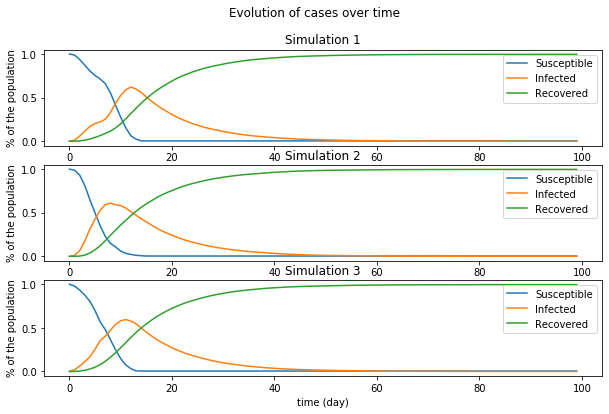

In [9]:
part3.strategy_simulation(nodes_list, edges_list, strategy="random")

We can see that this strategy is not really efficient as the curves are really similar to the initial case where we haven't modify the network.

Epidemic stopped after 100.34 days | 100.34 days elapsed | 12.5% susceptible, 0.0% infected, 87.5% recovered
Epidemic stopped after 100.56 days | 100.56 days elapsed | 57.7% susceptible, 0.0% infected, 42.3% recovered
Epidemic stopped after 99.60 days | 99.60 days elapsed | 24.5% susceptible, 0.0% infected, 75.5% recovered
Epidemic stopped after 98.53 days | 98.53 days elapsed | 24.2% susceptible, 0.0% infected, 75.8% recovered
Epidemic stopped after 104.36 days | 104.36 days elapsed | 7.4% susceptible, 0.0% infected, 92.6% recovered
By following strategy random, on day 30, the average of susceptible people is 6958.4, of infected is 3202.4 and of recovered is 16320.2


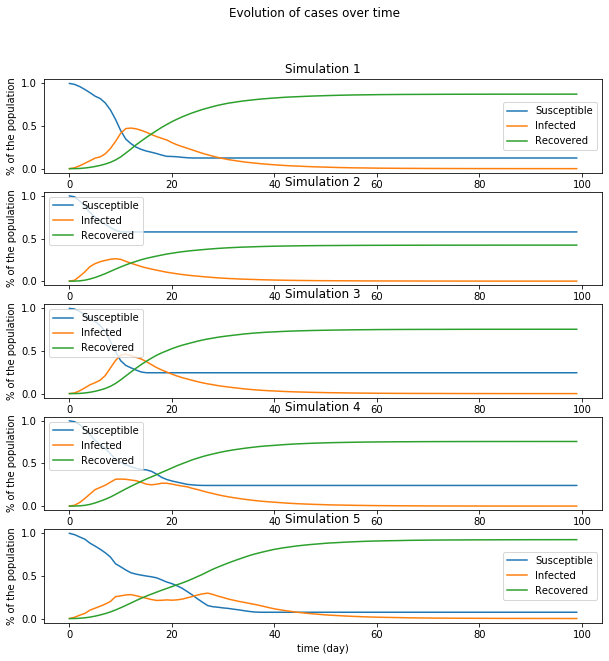

In [10]:
part3.strategy_simulation(nodes_list, edges_list, strategy="random", budget=10000, sim_nb=5)

We get a significant improvement but the results have a high variability and we cut around 20% of the edges in the network. It isn't a really reliable and cost effective solution.

#### Exercise 2.11: Strategy 2

Now we have to implement a strategy to maintain the epidemy under control. We thought about three of them:

- Reduce the "centrality" of the graph
- Isolate high degree node
- Partition the graph in communities


### High betweenness method

The idea behind this strategy is that if we cut the edges with the highest edge-betweenness (i.e. which are most present in shortest paths in the graph). Then it would take more time to reach any node and thus letting the time for the node to recover before containing a huge number of neighbours. For this we used the edge_betweenness_centrality function of the library networkx. It computes for every pair of nodes the shortest path between them using the Disjktra algorithm and then for each edges, compute the percentage of shortest paths that contain it. This is really computationnal costly (we used a good portion of the cluster for around 1 hour, so it may not be the first choice. Further more it produces better result that the random strategy but not outstanding ones.

In [11]:
max_centered_edges = part3.extract_max_centered_edges() #have been previously computed using the cluster and the function https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.edge_betweenness_centrality.html#networkx.algorithms.centrality.edge_betweenness_centrality

Here we can visualize the edges with a high betweenness, which contains many bridges which makes sense because they are needed to connect the graph. This is a good thing to cut them because it allows us to cut the graph in several connected components.

In [ ]:
Graph_high_centrality = nx.nx.Graph()
Graph_high_centrality.add_nodes_from(nodes_list)
Graph_high_centrality.add_edges_from(max_centered_edges[:2500])
part3.draw_graph(Graph_high_centrality,title="View of high centrality edges",edge_width=10.0)

Now we can see the results of multiple simulation using our strategy of high betweenness:

Epidemic stopped after 108.69 days | 108.69 days elapsed | 56.4% susceptible, 0.0% infected, 43.6% recovered
Epidemic stopped after 102.95 days | 102.95 days elapsed | 66.3% susceptible, 0.0% infected, 33.7% recovered
Epidemic stopped after 117.81 days | 117.81 days elapsed | 56.3% susceptible, 0.0% infected, 43.7% recovered
Epidemic stopped after 99.88 days | 99.88 days elapsed | 66.3% susceptible, 0.0% infected, 33.7% recovered
Epidemic stopped after 131.40 days | 131.40 days elapsed | 56.3% susceptible, 0.0% infected, 43.7% recovered
By following strategy betweenness, on day 30, the average of susceptible people is 15972.4, of infected is 939.0 and of recovered is 9569.6


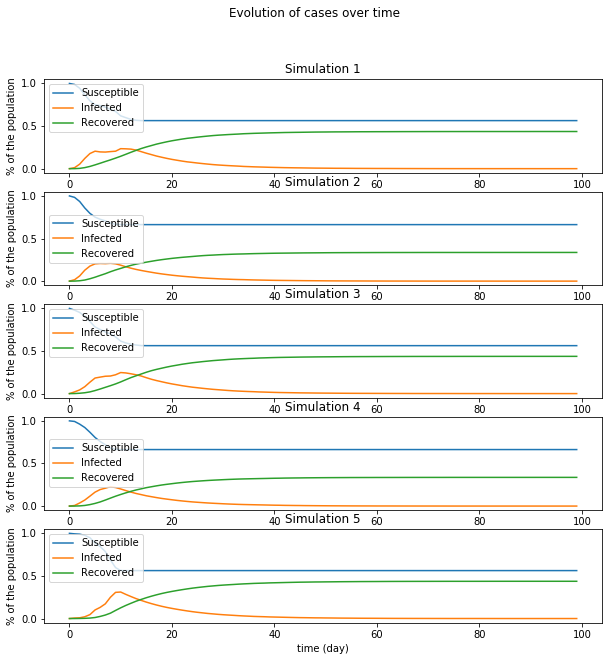

In [12]:
part3.strategy_simulation(nodes_list, edges_list, sim_nb=5, budget=2500, strategy="betweenness")

The results are much better than the random strategy. In average we are better than the random strategy with 4 times less edges removed. But the problem here is the cost to compute the edge_betweenness of the graph which is really computationnaly costly. So we should probably looking for other options

### Vaccination method (high degree node)

Another possible strategies (and more realistic one) is the vaccination. If you want to slow down the epidemy, the main target of the vaccination should be the people with a lot of contacts, i.e. high degree node (we suppose here that the vaccination avoid also to contaminate other people). This is not a really good idea in our situation as the cost to get rid of a high degree node is really high and thus we will spend a lot of edges on only a really small fraction of our graph and thus we find ourself in a position similar to the random case (maybe worse).

Epidemic stopped after 101.50 days | 101.50 days elapsed | 2.6% susceptible, 0.0% infected, 97.4% recovered
Epidemic stopped after 100.04 days | 100.04 days elapsed | 2.6% susceptible, 0.0% infected, 97.4% recovered
Epidemic stopped after 100.69 days | 100.69 days elapsed | 2.7% susceptible, 0.0% infected, 97.3% recovered
Epidemic stopped after 101.91 days | 101.91 days elapsed | 2.6% susceptible, 0.0% infected, 97.4% recovered
Epidemic stopped after 101.19 days | 101.19 days elapsed | 2.6% susceptible, 0.0% infected, 97.4% recovered
By following strategy vaccination, on day 30, the average of susceptible people is 692.4, of infected is 2964.0 and of recovered is 22824.6


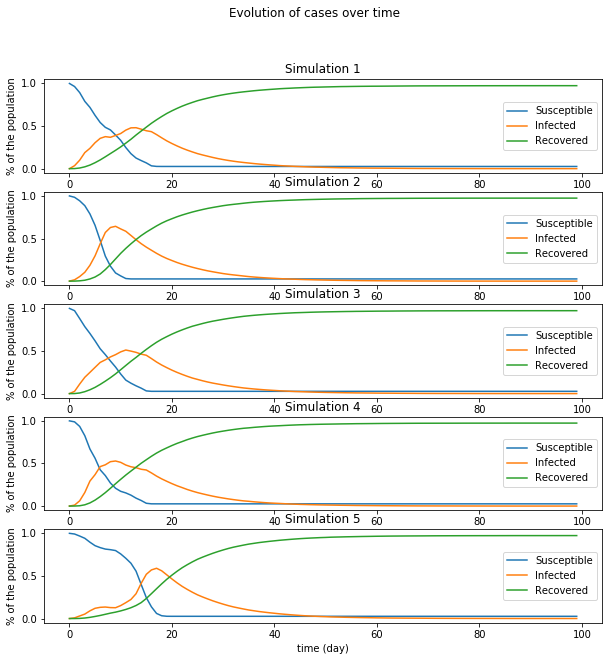

In [13]:
part3.strategy_simulation(nodes_list, edges_list, sim_nb = 5, budget=2500, strategy="vaccination")

We can effectively see that it is really similar to the random case and thus it is a bad strategy (but irl it is a great one!)

### Community method

The idea behind the last strategy is to separate the graph into strongly connected community and to isolate these communities from the rest of the network. Like this, an epidemy that would start in a community cannot extend to the rest of the network, preserving the vast majority of the population. We implemented it by using the Clauset-Newman-Moore greedy modularity maximization, present in the function greedy_modularity_communities of the library networkx (https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.modularity_max.greedy_modularity_communities.html). Once we have our communities we use method from the boudaries section of networkx to find the edges between every communities. Then we cut them. You can see below a representation of the different communities and the edges between them. This method is computationally efficient and provide excellent result, this is the one we should use to fight the epidemy.

Note that we cut at max ~750 edges because this is the number of boudary edges. So incrementing the budget over 750 won't result in any changes. To optimize even more this strategy we could implement a reccurent function that works on the communities of the initial graph to split them into sub-communities, etc. We prefered exploring various strategy rather than optimizing even more this strategy that reaches already 97% of susceptible at day 30 in average.

In [14]:
communities = nx.algorithms.community.greedy_modularity_communities(G)

In [ ]:
part3.draw_communities(G, communities, boundaries=True)

Epidemic stopped after 75.32 days | 75.32 days elapsed | 97.1% susceptible, 0.0% infected, 2.9% recovered
Epidemic stopped after 82.22 days | 82.22 days elapsed | 96.5% susceptible, 0.0% infected, 3.5% recovered
Epidemic stopped after 59.66 days | 59.66 days elapsed | 98.7% susceptible, 0.0% infected, 1.3% recovered
Epidemic stopped after 58.97 days | 58.97 days elapsed | 97.5% susceptible, 0.0% infected, 2.5% recovered
Epidemic stopped after 78.66 days | 78.66 days elapsed | 97.2% susceptible, 0.0% infected, 2.8% recovered
By following strategy community, on day 30, the average of susceptible people is 25796.6, of infected is 35.4 and of recovered is 649.0


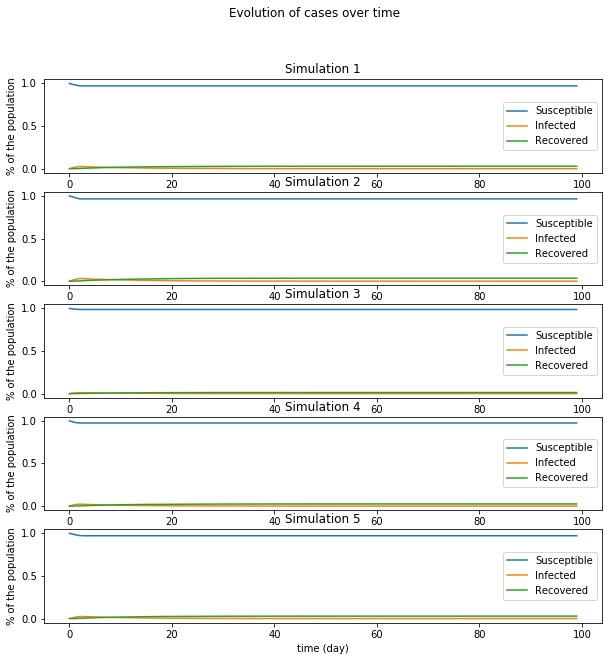

In [15]:
part3.strategy_simulation(nodes_list, edges_list, budget=2500, sim_nb=5, strategy="community")

This method is really efficient as we can maintain almost the entire network safe. This is rather computationnal effective especially when you look at the results.

## Cost/Effectiveness comparison

To have a clearer view of the real "value" of our strategy we provide a small graph of their cost-effectiveness

In [16]:
random = []
vaccination = []
betweenness = []
community = []
strategies = ["random","vaccination","betweenness","community"]
budgets = [100,200,300,400,500,600,700,800,900,1000,1500,2000,2500,5000,7500,10000]
for b in budgets:
    random.append(part3.compute_mean_susceptible(nodes_list, edges_list, b, "random"))
    vaccination.append(part3.compute_mean_susceptible(nodes_list, edges_list, b, "vaccination"))
    betweenness.append(part3.compute_mean_susceptible(nodes_list, edges_list, b, "betweenness"))
    community.append(part3.compute_mean_susceptible(nodes_list, edges_list, b, "community"))

Epidemic stopped after 101.87 days | 101.87 days elapsed | 0.1% susceptible, 0.0% infected, 99.9% recovered
Epidemic stopped after 103.99 days | 103.99 days elapsed | 0.1% susceptible, 0.0% infected, 99.9% recovered
Epidemic stopped after 107.28 days | 107.28 days elapsed | 0.1% susceptible, 0.0% infected, 99.9% recovered
Epidemic stopped after 104.56 days | 104.56 days elapsed | 0.1% susceptible, 0.0% infected, 99.9% recovered
Epidemic stopped after 87.28 days | 87.28 days elapsed | 0.1% susceptible, 0.0% infected, 99.9% recovered
Epidemic stopped after 102.96 days | 102.96 days elapsed | 0.1% susceptible, 0.0% infected, 99.9% recovered
Epidemic stopped after 101.07 days | 101.07 days elapsed | 0.2% susceptible, 0.0% infected, 99.8% recovered
Epidemic stopped after 120.80 days | 120.80 days elapsed | 0.3% susceptible, 0.0% infected, 99.7% recovered
Epidemic stopped after 111.20 days | 111.20 days elapsed | 0.2% susceptible, 0.0% infected, 99.8% recovered
Epidemic stopped after 114.06 

Epidemic stopped after 128.88 days | 128.88 days elapsed | 0.2% susceptible, 0.0% infected, 99.7% recovered
Epidemic stopped after 100.02 days | 100.02 days elapsed | 0.2% susceptible, 0.0% infected, 99.7% recovered
Epidemic stopped after 70.26 days | 70.26 days elapsed | 80.5% susceptible, 0.0% infected, 19.5% recovered
Epidemic stopped after 100.71 days | 100.71 days elapsed | 20.9% susceptible, 0.0% infected, 79.1% recovered
Epidemic stopped after 82.77 days | 82.77 days elapsed | 80.5% susceptible, 0.0% infected, 19.5% recovered
Epidemic stopped after 98.20 days | 98.20 days elapsed | 68.9% susceptible, 0.0% infected, 31.1% recovered
Epidemic stopped after 131.81 days | 131.81 days elapsed | 68.9% susceptible, 0.0% infected, 31.1% recovered
Epidemic stopped after 103.72 days | 103.72 days elapsed | 69.6% susceptible, 0.0% infected, 30.4% recovered
Epidemic stopped after 103.85 days | 103.85 days elapsed | 0.2% susceptible, 0.0% infected, 99.8% recovered
Epidemic stopped after 98.32

Epidemic stopped after 97.45 days | 97.45 days elapsed | 56.3% susceptible, 0.0% infected, 43.7% recovered
Epidemic stopped after 61.97 days | 61.97 days elapsed | 98.2% susceptible, 0.0% infected, 1.8% recovered
Epidemic stopped after 93.21 days | 93.21 days elapsed | 98.3% susceptible, 0.0% infected, 1.7% recovered
Epidemic stopped after 68.30 days | 68.30 days elapsed | 97.2% susceptible, 0.0% infected, 2.8% recovered
Epidemic stopped after 105.03 days | 105.03 days elapsed | 81.0% susceptible, 0.0% infected, 19.0% recovered
Epidemic stopped after 103.38 days | 103.38 days elapsed | 23.4% susceptible, 0.0% infected, 76.6% recovered
Epidemic stopped after 1.11 days | 1.11 days elapsed | 100.0% susceptible, 0.0% infected, 0.0% recovered
Epidemic stopped after 14.53 days | 14.53 days elapsed | 100.0% susceptible, 0.0% infected, 0.0% recovered
Epidemic stopped after 90.21 days | 90.21 days elapsed | 79.1% susceptible, 0.0% infected, 20.9% recovered
Epidemic stopped after 102.43 days | 1

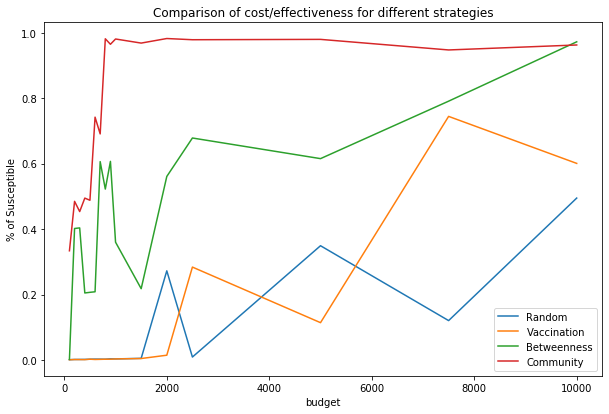

In [17]:
fig, ax = plt.subplots(figsize=(10,6.5))
ax.set_title("Comparison of cost/effectiveness for different strategies") 
ax.set_xlabel("budget")
ax.set_ylabel("% of Susceptible")
ax.plot(budgets, random, label="Random")
ax.plot(budgets, vaccination, label="Vaccination")
ax.plot(budgets, betweenness, label="Betweenness")
ax.plot(budgets, community, label="Community")
ax.legend()

We can see that the community strategy is growing exponentially reaching quickly around 97% of Susceptible. The betweenness one is slightly better than linear, but if we compare to its computationnal cost, it has a really bad cost-effectiveness. The vaccination and random strategy are sub-linear and thus pretty inneficient.